# Objective: Convolutional Neural Network Classification Using Augmented CIFAR-10
Here, I'm going to build an convolutional neural network classification model using PyTorch using augmented CIFAR-10 training data set.

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Load Data
This covers how to download the data and load the data into the code.

In [2]:
# ref: https://pytorch.org/vision/0.9/transforms.html
transformer_train = transforms.Compose([
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # transforms.RandomPerspective(),
    transforms.ToTensor(),
])

# load train dataset for training
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transformer_train,
    download=True
)

# load train dataset for testing
train_dataset_original = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# analyze train dataset
train_dataset.data.shape
# set(train_dataset.targets)

(50000, 32, 32, 3)

In [4]:
# load test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

Files already downloaded and verified


In [5]:
# analyze test dataset
test_dataset.data.shape

(10000, 32, 32, 3)

## Preprocess Data
This covers how to create batch using DataLoader.

In [6]:
# get the number of classes
K = len(set(train_dataset.targets))
print(f"The number of classes: {K}")

The number of classes: 10


In [7]:
# dataloader to automatically generate batches in the training loop with shuffling
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
train_loader_original = torch.utils.data.DataLoader(dataset=train_dataset_original,
                                                    batch_size=batch_size,
                                                    shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [8]:
# check whether the dataloader works okay or not
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=1,
                                         shuffle=True)
for x, y in tmp_loader:
    print(x)
    print(x.shape)
    # [batch_size, num_channels, image_height, image_width]
    break

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.2980, 0.2941, 0.2902,  ..., 0.0000, 0.0000, 0.0000],
          [0.3451, 0.3569, 0.3804,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2431, 0.2471, 0.2627,  ..., 0.0000, 0.0000, 0.0000],
          [0.2314, 0.2510, 0.2824,  ..., 0.0000, 0.0000, 0.0000],
          [0.2588, 0.2706, 0.2510,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4157, 0.4078, 0.4039,  ..., 0.0000, 0.0000, 0.0000],
          [0.4549, 0.4706, 0.4902,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2784, 0.2863, 0.3020,  ..., 0.0000, 0.0000, 0.0000],
          [0.2706, 0.2863, 0.3255,  ..., 0.0000, 0.0000, 0.0000],
          [0.3059, 0.3098, 0.2902,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.5647, 0.5569, 0.5451,  ..., 0.0000, 0.0000, 0.0000],
          [0.5647, 0.5804, 0.5961,  ..., 0

## Build Model
This covers how to build a convolutional neural network classification model using fashion MNIST dataset to train. Since the dataset is big enough, we can use GPU for faster process if available.

In [9]:
# define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        
        # define convolutional layers
        # H_out = floor[(H_in + 2*p - d(k-1) - 1)/s + 1]
        # image size: 32X32 -> 32X32 -> 16X16 (pooling)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )
        # image size: 16X16 -> 16X16 -> 8X8 (pooling)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )
        # image size: 8X8 -> 8X8 -> 4X4 (pooling)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        
        # define linear (fc) layers
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, K)
        
    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = X.view(-1, 128 * 4 * 4)
        X = F.dropout(X, p=0.5)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=0.2)
        return self.fc2(X)

In [10]:
# instantiate the model
model = CNN(K)

In [11]:
# activate gpu if possible, otherwise cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# send the model to the device
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [12]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## Training
This covers how to train the convolutional neural network classification model with the input data that we processed.

In [13]:
# build a function for training using batch gradient descent
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    # losses will be stored to plot the results
    # storage for losses per each epoch
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        # train mode
        model.train()
        t0 = datetime.now()
        train_loss = []
        
        for inputs, targets in train_loader:
            # send data to the device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # zero the parameter gradients to make sure they are zero
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # backward and optimize
            loss.backward()
            optimizer.step()
            
            # save the batch loss
            train_loss.append(loss.item())
        
        # get train loss per epoch as average loss of all the batches in that epoch
        train_loss = np.mean(train_loss)
        train_losses[epoch] = train_loss
        
        # test mode
        model.eval()
        test_loss = []
        
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        test_losses[epoch] = test_loss
        
        # calculate time spent
        dt = datetime.now() - t0
        
        # print out the result
        print(f"Epoch: {epoch+1}/{epochs}, Train loss: {train_loss:.4f}, Tess loss: {test_loss:.4f}, Duration: {dt}")
    
    return train_losses, test_losses

In [14]:
# get the result
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=80
)

Epoch: 1/80, Train loss: 1.4157, Tess loss: 1.1317, Duration: 0:00:11.238396
Epoch: 2/80, Train loss: 1.0060, Tess loss: 0.8973, Duration: 0:00:10.368857
Epoch: 3/80, Train loss: 0.8655, Tess loss: 0.8168, Duration: 0:00:10.404198
Epoch: 4/80, Train loss: 0.7695, Tess loss: 0.7702, Duration: 0:00:10.465142
Epoch: 5/80, Train loss: 0.7086, Tess loss: 0.8125, Duration: 0:00:10.390469
Epoch: 6/80, Train loss: 0.6624, Tess loss: 0.6906, Duration: 0:00:10.448399
Epoch: 7/80, Train loss: 0.6211, Tess loss: 0.6030, Duration: 0:00:10.447073
Epoch: 8/80, Train loss: 0.5864, Tess loss: 0.5847, Duration: 0:00:10.468791
Epoch: 9/80, Train loss: 0.5594, Tess loss: 0.5898, Duration: 0:00:10.476484
Epoch: 10/80, Train loss: 0.5366, Tess loss: 0.5475, Duration: 0:00:10.463563
Epoch: 11/80, Train loss: 0.5177, Tess loss: 0.5450, Duration: 0:00:10.476367
Epoch: 12/80, Train loss: 0.4985, Tess loss: 0.5349, Duration: 0:00:10.469567
Epoch: 13/80, Train loss: 0.4847, Tess loss: 0.5348, Duration: 0:00:10.47

## Result
This shows the result of the convolutional neural network classification model by showing the loss evolution and calculating the accuracy of the model.

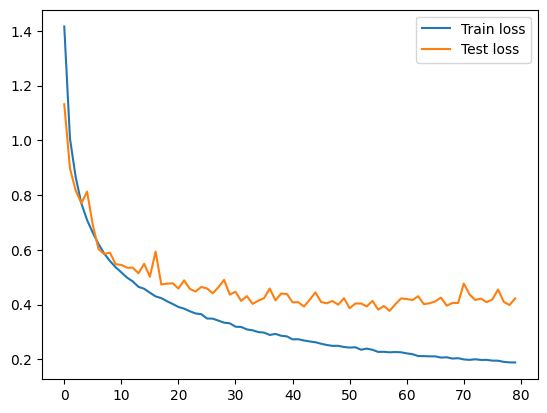

In [15]:
# plot the train loss and test loss per iteration
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [16]:
# calculate accuracy
# train accuracy
n_correct = 0.
n_total = 0.

model.eval()
for inputs, targets in train_loader_original:
    # send data to the device
    inputs, targets = inputs.to(device), targets.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # predictions by returning max value label
    _, predictions = torch.max(outputs, 1)
    
    # update numbers
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

# calculate train accuracy
train_acc = n_correct / n_total

# test accuracy
n_correct = 0.
n_total = 0.

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

# calculate test accuracy
test_acc = n_correct / n_total

# print the result
print(f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9473, Test accuracy: 0.8815


## Apendix: Confusion Matrix
This covers how to plot confusion matrix using the results that we got above.

In [17]:
# import libraries to plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[931  11  14   5   6   0   3   7  15   8]
 [  6 956   0   1   0   0   0   0   3  34]
 [ 45   3 837  36  24  13  10  23   5   4]
 [ 21   4  31 752  25 111  10  29   8   9]
 [  5   2  28  29 862  24  15  31   1   3]
 [  6   5  22  77  14 839   0  36   1   0]
 [ 14   4  44  51  12  11 858   4   2   0]
 [ 13   1   6   9  16  18   2 931   0   4]
 [ 60  11   1   8   0   1   1   1 900  17]
 [ 21  44   2   6   1   2   0   3   3 918]]


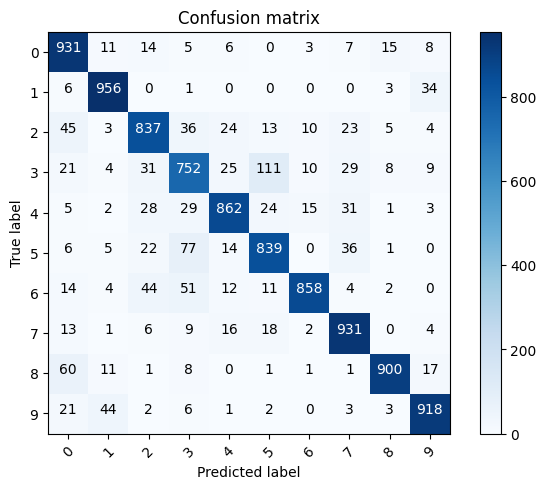

In [18]:
# get predictions in an array and plot the confusion matrix
x_test = test_dataset.data
y_test = test_dataset.targets
p_test = np.array([])

for inputs, targets in test_loader:
    # move data to device
    inputs = inputs.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # get predictions
    _, predictions = torch.max(outputs, 1)
    
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    # need to bring the result back to cpu to process the plot
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

## Apendix: Misclassified Cases
This covers examples of misclassification.

In [19]:
# label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

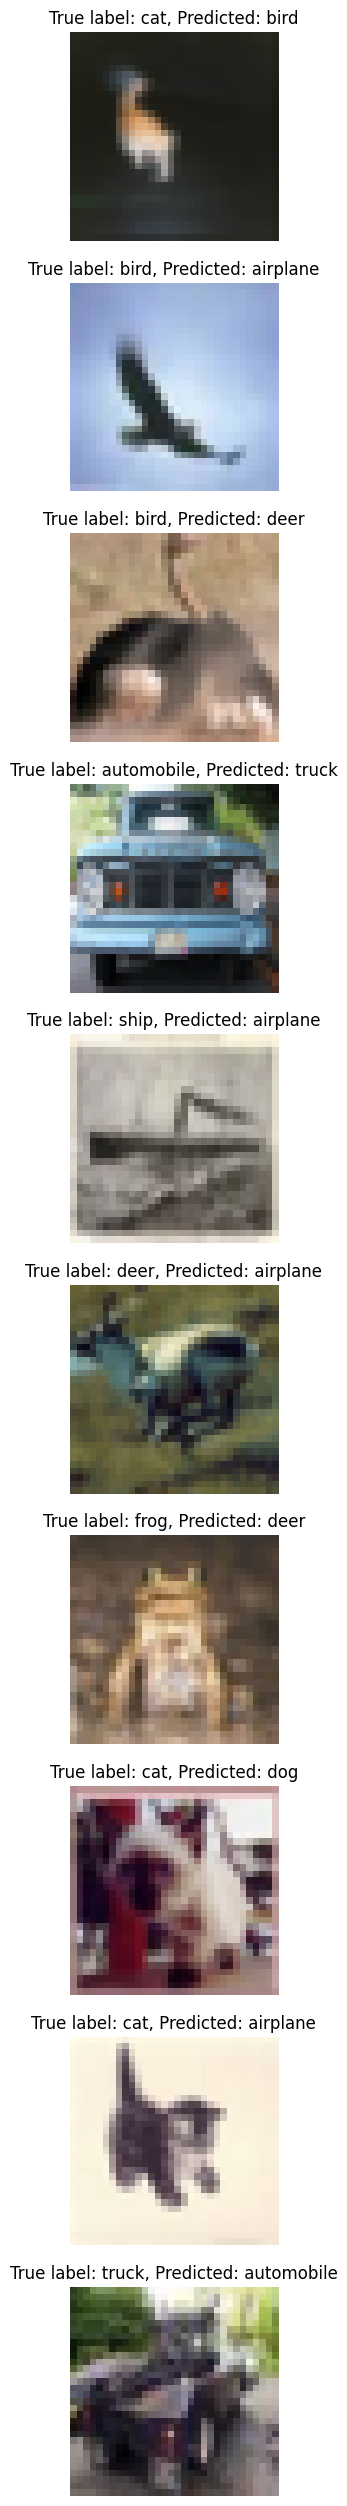

In [21]:
# show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
sample_idx = np.random.choice(misclassified_idx, 10, replace=False)
plt.figure(figsize=(32,32))
for j, i in enumerate(sample_idx):
  plt.subplot(10, 1, j + 1)
  plt.axis('off')
  plt.imshow(x_test[i].reshape(32,32,3))
  plt.title("True label: %s, Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));